In [ ]:
# Block 1: Setup and Mounting Google Drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # Use notebook-friendly progress bar
from google.colab import drive



# --- Set the path to your project folder ---
# ‼️ IMPORTANT: Change this path to match your folder structure on Google Drive ‼️
PROJECT_PATH = '/content/drive/MyDrive/SAGIN/SAGIN/csvs/'
print(f"📁 Project path set to: {PROJECT_PATH}")

# --- Configure plot style ---
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (18, 12)

📁 Project path set to: /content/drive/MyDrive/SAGIN/SAGIN/csvs/


In [ ]:
# Block 2: Load and Pre-process All Input Data

print("🔄 Loading input CSV files...")

try:
    # Load user data
    user_mobility_df = pd.read_csv(PROJECT_PATH + 'user_mobility.csv')
    user_config_df = pd.read_csv(PROJECT_PATH + 'user_config.csv')

    # Load relay data
    ground_mobility_df = pd.read_csv(PROJECT_PATH + 'ground_relay_mobility.csv')
    air_mobility_df = pd.read_csv(PROJECT_PATH + 'air_relay_mobility.csv')
    space_mobility_df = pd.read_csv(PROJECT_PATH + 'space_relay_mobility.csv')
    relay_config_df = pd.read_csv(PROJECT_PATH + 'relay_config.csv')

    # Combine all relay mobility data into a single DataFrame
    relay_mobility_df = pd.concat([ground_mobility_df, air_mobility_df, space_mobility_df], ignore_index=True)

    print("✅ All data loaded successfully.")
    print(f"Loaded {len(user_mobility_df['vehicle_id'].unique())} users and {len(relay_mobility_df['relay_id'].unique())} relays.")

    # Display the first few rows of the main dataframes to verify
    print("\n--- User Mobility Data ---")
    print(user_mobility_df.head())
    print("\n--- Relay Mobility Data ---")
    print(relay_mobility_df.head())
    print("\n--- Relay Configuration ---")
    print(relay_config_df.head())

except FileNotFoundError as e:
    print(f"❌ ERROR: File not found. Please check your PROJECT_PATH and file names.")
    print(f"Details: {e}")

🔄 Loading input CSV files...
✅ All data loaded successfully.
Loaded 50 users and 9 relays.

--- User Mobility Data ---
   timestep vehicle_id         x        y    z  speed
0         1       veh0   9000.00  1981.79  0.0  18.21
1         1       veh1  10000.00  4000.00  0.0  17.63
2         1       veh2   9015.98  8000.00  0.0  15.98
3         1       veh3   3981.48     0.00  0.0  18.52
4         1       veh4   1011.55  4000.00  0.0  11.55

--- Relay Mobility Data ---
   timestep relay_id       x       y     z
0         1    gbs_1  1000.0  1000.0  25.0
1         1    gbs_2  1000.0  9000.0  25.0
2         1    gbs_3  9000.0  1000.0  25.0
3         1    gbs_4  9000.0  9000.0  25.0
4         1    gbs_5  5000.0  5000.0  30.0

--- Relay Configuration ---
  relay_id type  max_bandwidth_bps  max_energy_joules
0    gbs_1  GBS         1000000000           10000000
1    gbs_2  GBS         1000000000           10000000
2    gbs_3  GBS         1000000000           10000000
3    gbs_4  GBS         1

In [ ]:
# Block 3: The Digital Twin (DT) Prediction Engine

print("🧠 Building the Digital Twin prediction models...")

# --- Pre-calculate positions for faster lookups ---
# This dictionary structure makes getting a position at time 't' much faster
user_positions = {t: df.set_index('vehicle_id')[['x', 'y', 'z']] for t, df in user_mobility_df.groupby('timestep')}
relay_positions = {t: df.set_index('relay_id')[['x', 'y', 'z']] for t, df in relay_mobility_df.groupby('timestep')}
relay_types = relay_config_df.set_index('relay_id')['type'].to_dict()

def predict_network_state(time):
    """Predicts rates, demands, and costs for a given timestep."""
    state = {'rates': {}, 'demands': {}, 'costs': {}}

    # Get all positions at the current time
    current_user_pos = user_positions.get(time, {})
    current_relay_pos = relay_positions.get(time, {})

    # Predict user demands
    for user_id in current_user_pos.index:
        baseline_demand = 2 # Mbps
        spike = np.random.poisson(0.5) * 10 # Occasional spikes for video
        state['demands'][user_id] = baseline_demand + spike

    # Predict rates and costs for each user-relay pair
    for user_id, user_pos in current_user_pos.iterrows():
        for relay_id, relay_pos in current_relay_pos.iterrows():
            distance = np.linalg.norm(user_pos - relay_pos) / 1000  # in km

            # --- Rate Prediction ---
            # Simplified model: rate decreases with distance squared, depends on relay type
            relay_type = relay_types[relay_id]
            if relay_type == 'LEO':
                base_rate = 200 / (1 + distance**2) # High base rate, less sensitive to ground distance
            elif relay_type == 'UAV':
                base_rate = 150 / (1 + distance**2)
            else: # GBS
                base_rate = 100 / (1 + distance**2)
            predicted_rate = base_rate + np.random.normal(0, 5) # Add channel noise
            state['rates'][(user_id, relay_id)] = max(5, predicted_rate) # Ensure a minimum rate

            # --- Cost Prediction ---
            # Model: cost is a mix of energy (distance) and latency (fixed per type)
            latency_cost = {'GBS': 5, 'UAV': 20, 'LEO': 150}.get(relay_type, 50)
            energy_cost = distance * 0.5
            state['costs'][(user_id, relay_id)] = latency_cost + energy_cost

    return state

print("✅ Digital Twin models are ready.")

🧠 Building the Digital Twin prediction models...
✅ Digital Twin models are ready.


In [ ]:
# Block 4: Stackelberg Game and Simulation Runner

print("⚙️ Defining the Stackelberg Game and Simulation Logic...")

def solve_stackelberg_equilibrium(network_state, initial_prices):
    """Simulates the iterative game to find equilibrium."""
    prices = initial_prices.copy()
    user_assignments = {}

    for i in range(15): # Max 15 iterations to converge
        # 1. Users' Choice (Best Response)
        for user_id in network_state['demands']:
            best_utility = -np.inf
            best_relay = None
            for relay_id in prices:
                rate = network_state['rates'].get((user_id, relay_id), 0)
                cost = network_state['costs'].get((user_id, relay_id), np.inf)
                price = prices[relay_id]
                utility = rate - price * cost
                if utility > best_utility:
                    best_utility = utility
                    best_relay = relay_id
            user_assignments[user_id] = best_relay

        # 2. Relays' Response (Price Update)
        relay_load = {relay_id: 0 for relay_id in prices}
        for user, relay in user_assignments.items():
            if relay: relay_load[relay] += 1

        for relay_id in prices:
            # Simple heuristic: increase price if loaded, decrease if empty
            if relay_load[relay_id] > 5: # Arbitrary load threshold
                prices[relay_id] *= 1.2
            elif relay_load[relay_id] == 0:
                prices[relay_id] *= 0.85

    return user_assignments, i + 1 # Return assignments and iterations taken

def jains_fairness(rates):
    """Calculates Jain's Fairness Index for a list of data rates."""
    if not rates or sum(rates) == 0:
        return 0
    rates = np.array(rates)
    return (np.sum(rates)**2) / (len(rates) * np.sum(rates**2))


def run_simulation(strategy, duration=300): # Run for 300s for speed, change to 3600 for full run
    """Runs the full simulation for a given strategy ('stackelberg' or 'rag')."""
    print(f"\n▶️ Running simulation with strategy: {strategy.upper()}...")
    results = []
    relay_ids = relay_config_df['relay_id'].unique()

    for t in tqdm(range(1, duration + 1), desc=f"Simulating {strategy}"):
        # Step 1: Predict state with DT
        state = predict_network_state(t)
        if not state['demands']: continue # Skip if no users are active

        # Step 2: Initialize prices based on strategy
        if strategy == 'stackelberg':
            # Baseline: all relays start with a default price
            initial_prices = {relay_id: 1.0 for relay_id in relay_ids}
        else: # 'rag'
            # RAG Simulation: start with smarter prices based on relay type
            # This simulates the RAG agent providing an intelligent starting point.
            initial_prices = {
                rid: 0.5 if 'gbs' in rid else (1.5 if 'uav' in rid else 3.0)
                for rid in relay_ids
            }

        # Step 3: Solve the game
        assignments, iterations = solve_stackelberg_equilibrium(state, initial_prices)

        # Step 4: Log metrics for this timestep
        achieved_rates = [state['rates'].get((u, r), 0) for u, r in assignments.items()]
        total_utility = sum(achieved_rates)
        fairness = jains_fairness(achieved_rates)

        results.append({
            'time': t,
            'strategy': strategy,
            'total_utility': total_utility,
            'avg_delay': np.mean([state['costs'].get((u, r), 0) for u,r in assignments.items()]),
            'iterations': iterations,
            'fairness': fairness
        })

    return pd.DataFrame(results)

print("✅ Simulation logic is ready.")

⚙️ Defining the Stackelberg Game and Simulation Logic...
✅ Simulation logic is ready.


In [ ]:
# Block 5: Execute Both Simulation Scenarios

# WARNING: This step can be slow. I've set the default duration to 300 seconds (5 mins).
# For your final graphs, change duration=300 to duration=3600 in the function calls.
SIM_DURATION = 300

# Run the baseline Stackelberg simulation
stackelberg_results_df = run_simulation('stackelberg', duration=SIM_DURATION)

# Run the RAG-augmented simulation
rag_results_df = run_simulation('rag', duration=SIM_DURATION)

print("\n🏁 Both simulations complete!")
print("\n--- Baseline Stackelberg Results ---")
print(stackelberg_results_df.describe())
print("\n--- RAG-Augmented Results ---")
print(rag_results_df.describe())


▶️ Running simulation with strategy: STACKELBERG...


Simulating stackelberg:   0%|          | 0/300 [00:00<?, ?it/s]


▶️ Running simulation with strategy: RAG...


Simulating rag:   0%|          | 0/300 [00:00<?, ?it/s]


🏁 Both simulations complete!

--- Baseline Stackelberg Results ---
             time  total_utility   avg_delay  iterations    fairness
count  300.000000     300.000000  300.000000       300.0  300.000000
mean   150.500000    1759.306944   22.708765        15.0    0.625544
std     86.746758     201.636798   20.632199         0.0    0.062035
min      1.000000    1242.905562    8.497483        15.0    0.479285
25%     75.750000    1610.972557   11.557065        15.0    0.572381
50%    150.500000    1764.864626   13.921069        15.0    0.622423
75%    225.250000    1922.069435   22.598009        15.0    0.677758
max    300.000000    2184.802513  127.447703        15.0    0.757943

--- RAG-Augmented Results ---
             time  total_utility   avg_delay  iterations    fairness
count  300.000000     300.000000  300.000000       300.0  300.000000
mean   150.500000    1813.006715   10.695933        15.0    0.649725
std     86.746758     192.773513    1.124635         0.0    0.073052
min 


📊 Generating final comparison graphs...


/tmp/ipython-input-697122386.py:37: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=combined_results_df, x='iterations', hue='strategy', fill=True, ax=axes[2, 0])
/tmp/ipython-input-697122386.py:44: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  summary_df.plot(kind='bar', subplots=True, layout=(1, 4), figsize=(20, 4), ax=axes[2, 1], legend=False)


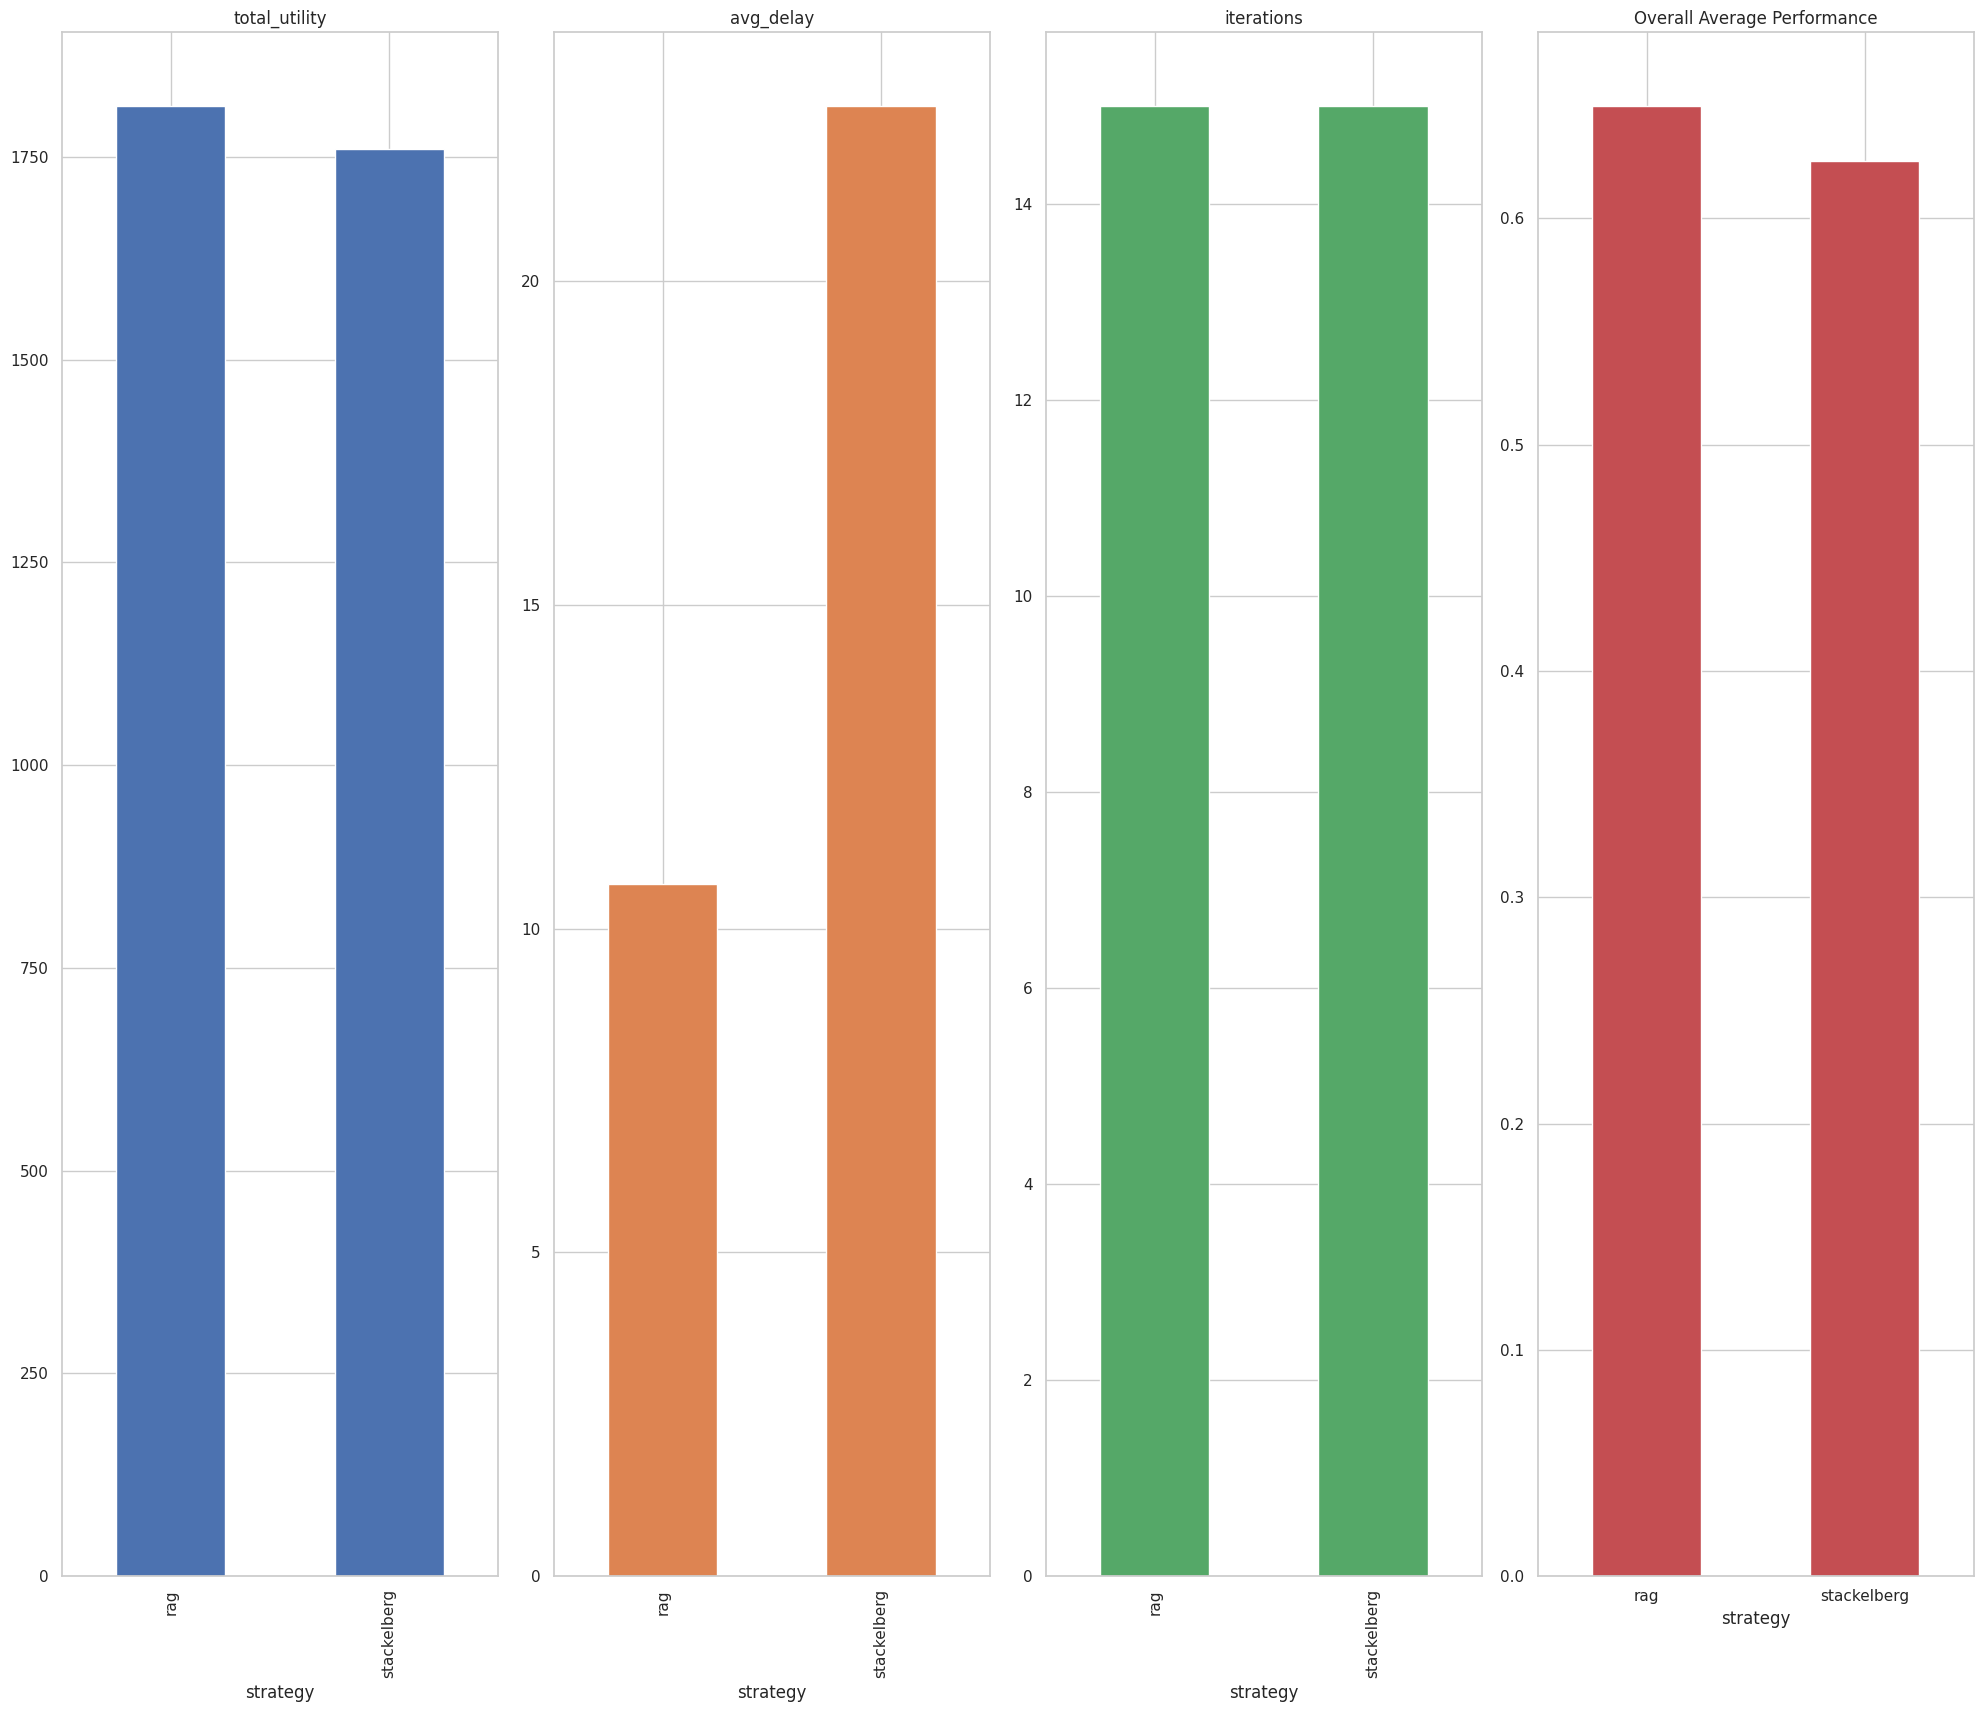


✅ All graphs generated.


In [ ]:
# Block 6: Generate and Display Final Graphs

print("\n📊 Generating final comparison graphs...")

# Combine results for easier plotting
combined_results_df = pd.concat([stackelberg_results_df, rag_results_df])

# Create a 3x2 grid of plots
fig, axes = plt.subplots(3, 2, figsize=(20, 18))
fig.suptitle('SAGIN Resource Scheduling: Stackelberg vs. RAG-Augmented Performance', fontsize=20)

# --- Graph 1: Total System Utility Over Time ---
sns.lineplot(ax=axes[0, 0], data=combined_results_df, x='time', y='total_utility', hue='strategy')
axes[0, 0].set_title('Total System Utility Over Time', fontsize=14)
axes[0, 0].set_xlabel('Time (seconds)')
axes[0, 0].set_ylabel('Total Data Rate (Mbps)')

# --- Graph 2: Average User Delay Over Time ---
sns.lineplot(ax=axes[0, 1], data=combined_results_df, x='time', y='avg_delay', hue='strategy')
axes[0, 1].set_title('Average User Delay (Cost) Over Time', fontsize=14)
axes[0, 1].set_xlabel('Time (seconds)')
axes[0, 1].set_ylabel('Average Delay/Cost Metric')

# --- Graph 3: Game Convergence Speed ---
sns.lineplot(ax=axes[1, 0], data=combined_results_df, x='time', y='iterations', hue='strategy')
axes[1, 0].set_title('Game Convergence Speed Over Time', fontsize=14)
axes[1, 0].set_xlabel('Time (seconds)')
axes[1, 0].set_ylabel('Iterations to Converge')

# --- Graph 4: Fairness Over Time ---
sns.lineplot(ax=axes[1, 1], data=combined_results_df, x='time', y='fairness', hue='strategy')
axes[1, 1].set_title('Resource Allocation Fairness (Jain\'s Index)', fontsize=14)
axes[1, 1].set_xlabel('Time (seconds)')
axes[1, 1].set_ylabel('Fairness Index (0 to 1)')

# --- Graph 5: Distribution of Convergence Iterations ---
sns.kdeplot(data=combined_results_df, x='iterations', hue='strategy', fill=True, ax=axes[2, 0])
axes[2, 0].set_title('Distribution of Convergence Iterations', fontsize=14)
axes[2, 0].set_xlabel('Iterations to Converge')
axes[2, 0].set_ylabel('Density')

# --- Graph 6: Overall Performance Summary ---
summary_df = combined_results_df.groupby('strategy').mean()[['total_utility', 'avg_delay', 'iterations', 'fairness']]
summary_df.plot(kind='bar', subplots=True, layout=(1, 4), figsize=(20, 4), ax=axes[2, 1], legend=False)
fig.axes[-1].set_title('Overall Average Performance') # The summary plot is the last axes
fig.axes[-1].tick_params(axis='x', rotation=0)

# Adjust layout and display the plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

print("\n✅ All graphs generated.")

In [ ]:
# Block 1: Setup and Data Loading

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from google.colab import drive



# --- Set the path to your project folder ---
# ‼️ IMPORTANT: Change this path to match your folder on Google Drive ‼️
PROJECT_PATH = '/content/drive/MyDrive/SAGIN/SAGIN/csvs/'
print(f"📁 Project path set to: {PROJECT_PATH}")

# --- Load all data files ---
print("🔄 Loading input CSV files...")
try:
    user_mobility_df = pd.read_csv(PROJECT_PATH + 'user_mobility.csv')
    relay_config_df = pd.read_csv(PROJECT_PATH + 'relay_config.csv')
    # Combine all relay mobility into one DataFrame
    relay_mobility_df = pd.concat([
        pd.read_csv(PROJECT_PATH + 'ground_relay_mobility.csv'),
        pd.read_csv(PROJECT_PATH + 'air_relay_mobility.csv'),
        pd.read_csv(PROJECT_PATH + 'space_relay_mobility.csv')
    ], ignore_index=True)
    print("✅ All data loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ ERROR: File not found. Please check your PROJECT_PATH and file names. Details: {e}")

# --- Configure plot style ---
sns.set_theme(style="darkgrid")

📁 Project path set to: /content/drive/MyDrive/SAGIN/SAGIN/csvs/
🔄 Loading input CSV files...
✅ All data loaded successfully.


In [ ]:
# Block 2: The Advanced Simulation Engine

print("🧠 Building the advanced simulation engine...")

# --- Pre-process data for fast lookups ---
user_positions = {t: df.set_index('vehicle_id')[['x', 'y', 'z', 'speed']] for t, df in user_mobility_df.groupby('timestep')}
relay_positions = {t: df.set_index('relay_id')[['x', 'y', 'z']] for t, df in relay_mobility_df.groupby('timestep')}
relay_types = relay_config_df.set_index('relay_id')['type'].to_dict()

# --- Digital Twin Models ---
def get_network_state(time, active_users, active_relays, mobility_factor=1.0, horizon=0):
    """Predicts network state for a future time (time + horizon)."""
    future_time = time + horizon
    state = {'rates': {}, 'costs': {}, 'energy': {}, 'actual_rates': {}}

    user_pos_t = user_positions.get(time, pd.DataFrame())
    relay_pos_t = relay_positions.get(time, pd.DataFrame())

    # Get ground truth positions at the future time for error calculation
    user_pos_future = user_positions.get(future_time, pd.DataFrame())

    if user_pos_t.empty or relay_pos_t.empty: return None

    for user_id in active_users:
      if user_id not in user_pos_t.index: continue
      user_pos = user_pos_t.loc[user_id]

      for relay_id in active_relays:
        if relay_id not in relay_pos_t.index: continue
        relay_pos = relay_pos_t.loc[relay_id]

        # Simulate mobility by scaling speed and predicting future position
        predicted_user_pos = user_pos[['x', 'y', 'z']] + (user_pos['speed'] * mobility_factor * horizon)
        distance = np.linalg.norm(predicted_user_pos - relay_pos) / 1000.0

        # Rate Prediction
        rate = 150 / (1 + distance**2) + np.random.normal(0, 3)
        state['rates'][(user_id, relay_id)] = max(5, rate)

        # Cost & Energy Prediction
        latency = {'GBS': 5, 'UAV': 20, 'LEO': 150}.get(relay_types[relay_id], 50)
        energy = distance * 0.5
        state['costs'][(user_id, relay_id)] = latency + energy
        state['energy'][(user_id, relay_id)] = energy

        # Calculate "actual" future rate for error comparison
        if not user_pos_future.empty and user_id in user_pos_future.index:
            actual_distance = np.linalg.norm(user_pos_future.loc[user_id][['x','y','z']] - relay_pos) / 1000.0
            actual_rate = 150 / (1 + actual_distance**2)
            state['actual_rates'][(user_id, relay_id)] = max(5, actual_rate)

    return state

# --- Main Simulation Runner ---
def run_simulation(params):
    """Runs a full simulation based on a dictionary of parameters."""
    strategy, duration, n_users, n_relays, mobility, horizon = params.values()

    results = []
    all_user_ids = sorted(user_mobility_df['vehicle_id'].unique())
    all_relay_ids = sorted(relay_mobility_df['relay_id'].unique())

    active_users = all_user_ids[:n_users]
    active_relays = all_relay_ids[:n_relays]

    for t in range(1, duration - horizon):
        state = get_network_state(t, active_users, active_relays, mobility, horizon)
        if not state or not state['rates']: continue

        # Initialize Prices
        if strategy == 'stackelberg':
            prices = {relay_id: 1.0 for relay_id in active_relays}
        else: # RAG: Smarter initial prices based on relay type
            prices = {rid: 0.5 if 'gbs' in rid else (1.5 if 'uav' in rid else 3.0) for rid in active_relays}

        # --- Stackelberg Game ---
        assignments = {}
        for i in range(15): # Max iterations
            user_choices = {}
            for user_id in active_users:
                utils = {r_id: state['rates'].get((user_id, r_id), 0) - p * state['costs'].get((user_id, r_id), np.inf)
                         for r_id, p in prices.items()}
                user_choices[user_id] = max(utils, key=utils.get) if utils else None

            if user_choices == assignments: break # Converged
            assignments = user_choices

            # Price update
            loads = {r: list(assignments.values()).count(r) for r in active_relays}
            for r_id in active_relays:
                if loads[r_id] > n_users / n_relays: prices[r_id] *= 1.1
                elif loads[r_id] == 0: prices[r_id] *= 0.9

        # --- Logging ---
        total_energy = sum(state['energy'].get((u, r), 0) for u, r in assignments.items())
        achieved_rates = [state['rates'].get((u, r), 0) for u, r in assignments.items()]
        actual_rates = [state['actual_rates'].get((u, r), 0) for u, r in assignments.items()]
        pred_error = np.mean([abs(p - a) for p, a in zip(achieved_rates, actual_rates) if a > 0])

        results.append({
            'strategy': strategy, 'num_users': n_users, 'num_relays': n_relays,
            'mobility': mobility, 'time_horizon': horizon, 'iterations': i + 1,
            'total_utility': sum(achieved_rates), 'avg_delay': np.mean([state['costs'].get((u,r),0) for u,r in assignments.items()]),
            'total_energy': total_energy, 'fairness': (np.sum(achieved_rates)**2)/(len(achieved_rates)*np.sum(np.square(achieved_rates))) if sum(achieved_rates)>0 else 0,
            'prediction_error': pred_error
        })

    return pd.DataFrame(results)

print("✅ Advanced simulation engine is ready.")

🧠 Building the advanced simulation engine...
✅ Advanced simulation engine is ready.


In [17]:
# Block 3: The Experiment Runner

# ‼️ WARNING: This block is computationally intensive and will take a long time.
# For a quick test, reduce the EXPERIMENT_DURATION and the number of items in the lists.
EXPERIMENT_DURATION = 100  # Duration in seconds for each run. Use 300+ for good results.

# --- Define the parameter space for the experiments ---
scenarios = []
strategies = ['stackelberg', 'rag']
user_counts = [20, 30, 40, 50]
relay_counts = [5, 7, 9]
mobility_factors = [0.5, 1.0, 1.5] # 0.5=Low, 1.0=Normal, 1.5=High
horizons = [1, 2, 3, 4, 5]

# Create a list of all simulation parameter sets
for strategy in strategies:
    # For user/energy graphs (fix other params)
    for n_users in user_counts:
        scenarios.append({'strategy': strategy, 'duration': EXPERIMENT_DURATION, 'n_users': n_users, 'n_relays': 9, 'mobility': 1.0, 'horizon': 1})
    # For relay graph (fix other params)
    for n_relays in relay_counts:
        scenarios.append({'strategy': strategy, 'duration': EXPERIMENT_DURATION, 'n_users': 50, 'n_relays': n_relays, 'mobility': 1.0, 'horizon': 1})
    # For mobility graph (fix other params)
    for mobility in mobility_factors:
        scenarios.append({'strategy': strategy, 'duration': EXPERIMENT_DURATION, 'n_users': 50, 'n_relays': 9, 'mobility': mobility, 'horizon': 1})
    # For prediction graph (fix other params)
    for horizon in horizons:
        scenarios.append({'strategy': strategy, 'duration': EXPERIMENT_DURATION, 'n_users': 50, 'n_relays': 9, 'mobility': 1.0, 'horizon': horizon})

# --- Run all experiments ---
print(f"🔥 Starting experiments. Total simulation runs: {len(scenarios)}")
all_results = []
for params in tqdm(scenarios, desc="Overall Progress"):
    run_result = run_simulation(params)
    all_results.append(run_result)

# Combine all results into a single master DataFrame
results_df = pd.concat(all_results, ignore_index=True)
print("\n🏁 All experiments complete!")
print("--- Final Results Summary ---")
print(results_df.head())

🔥 Starting experiments. Total simulation runs: 30


Overall Progress:   0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Block 3.5: Save Experiment Results to CSV

print("\n💾 Saving all experiment results to a CSV file...")

# Define the output filename
output_filename = PROJECT_PATH + 'sagin_simulation_results.csv'

try:
    # Save the DataFrame to CSV
    # index=False prevents pandas from writing the DataFrame index as a column
    results_df.to_csv(output_filename, index=False)
    print(f"✅ Results successfully saved to: {output_filename}")
except Exception as e:
    print(f"❌ ERROR: Could not save the file. Details: {e}")


💾 Saving all experiment results to a CSV file...
✅ Results successfully saved to: /content/drive/MyDrive/SAGIN/SAGIN/csvs/sagin_simulation_results.csv



📊 Generating final comparison graphs...


/tmp/ipython-input-1468391762.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Strategy')



💾 Saving the complete graph grid as a single file...
✅ Full figure saved to: /content/drive/MyDrive/SAGIN/SAGIN/csvs/sagin_all_graphs_summary.png

💾 Saving each subplot as an individual file...
✅ 6 individual graph files saved to your project folder.


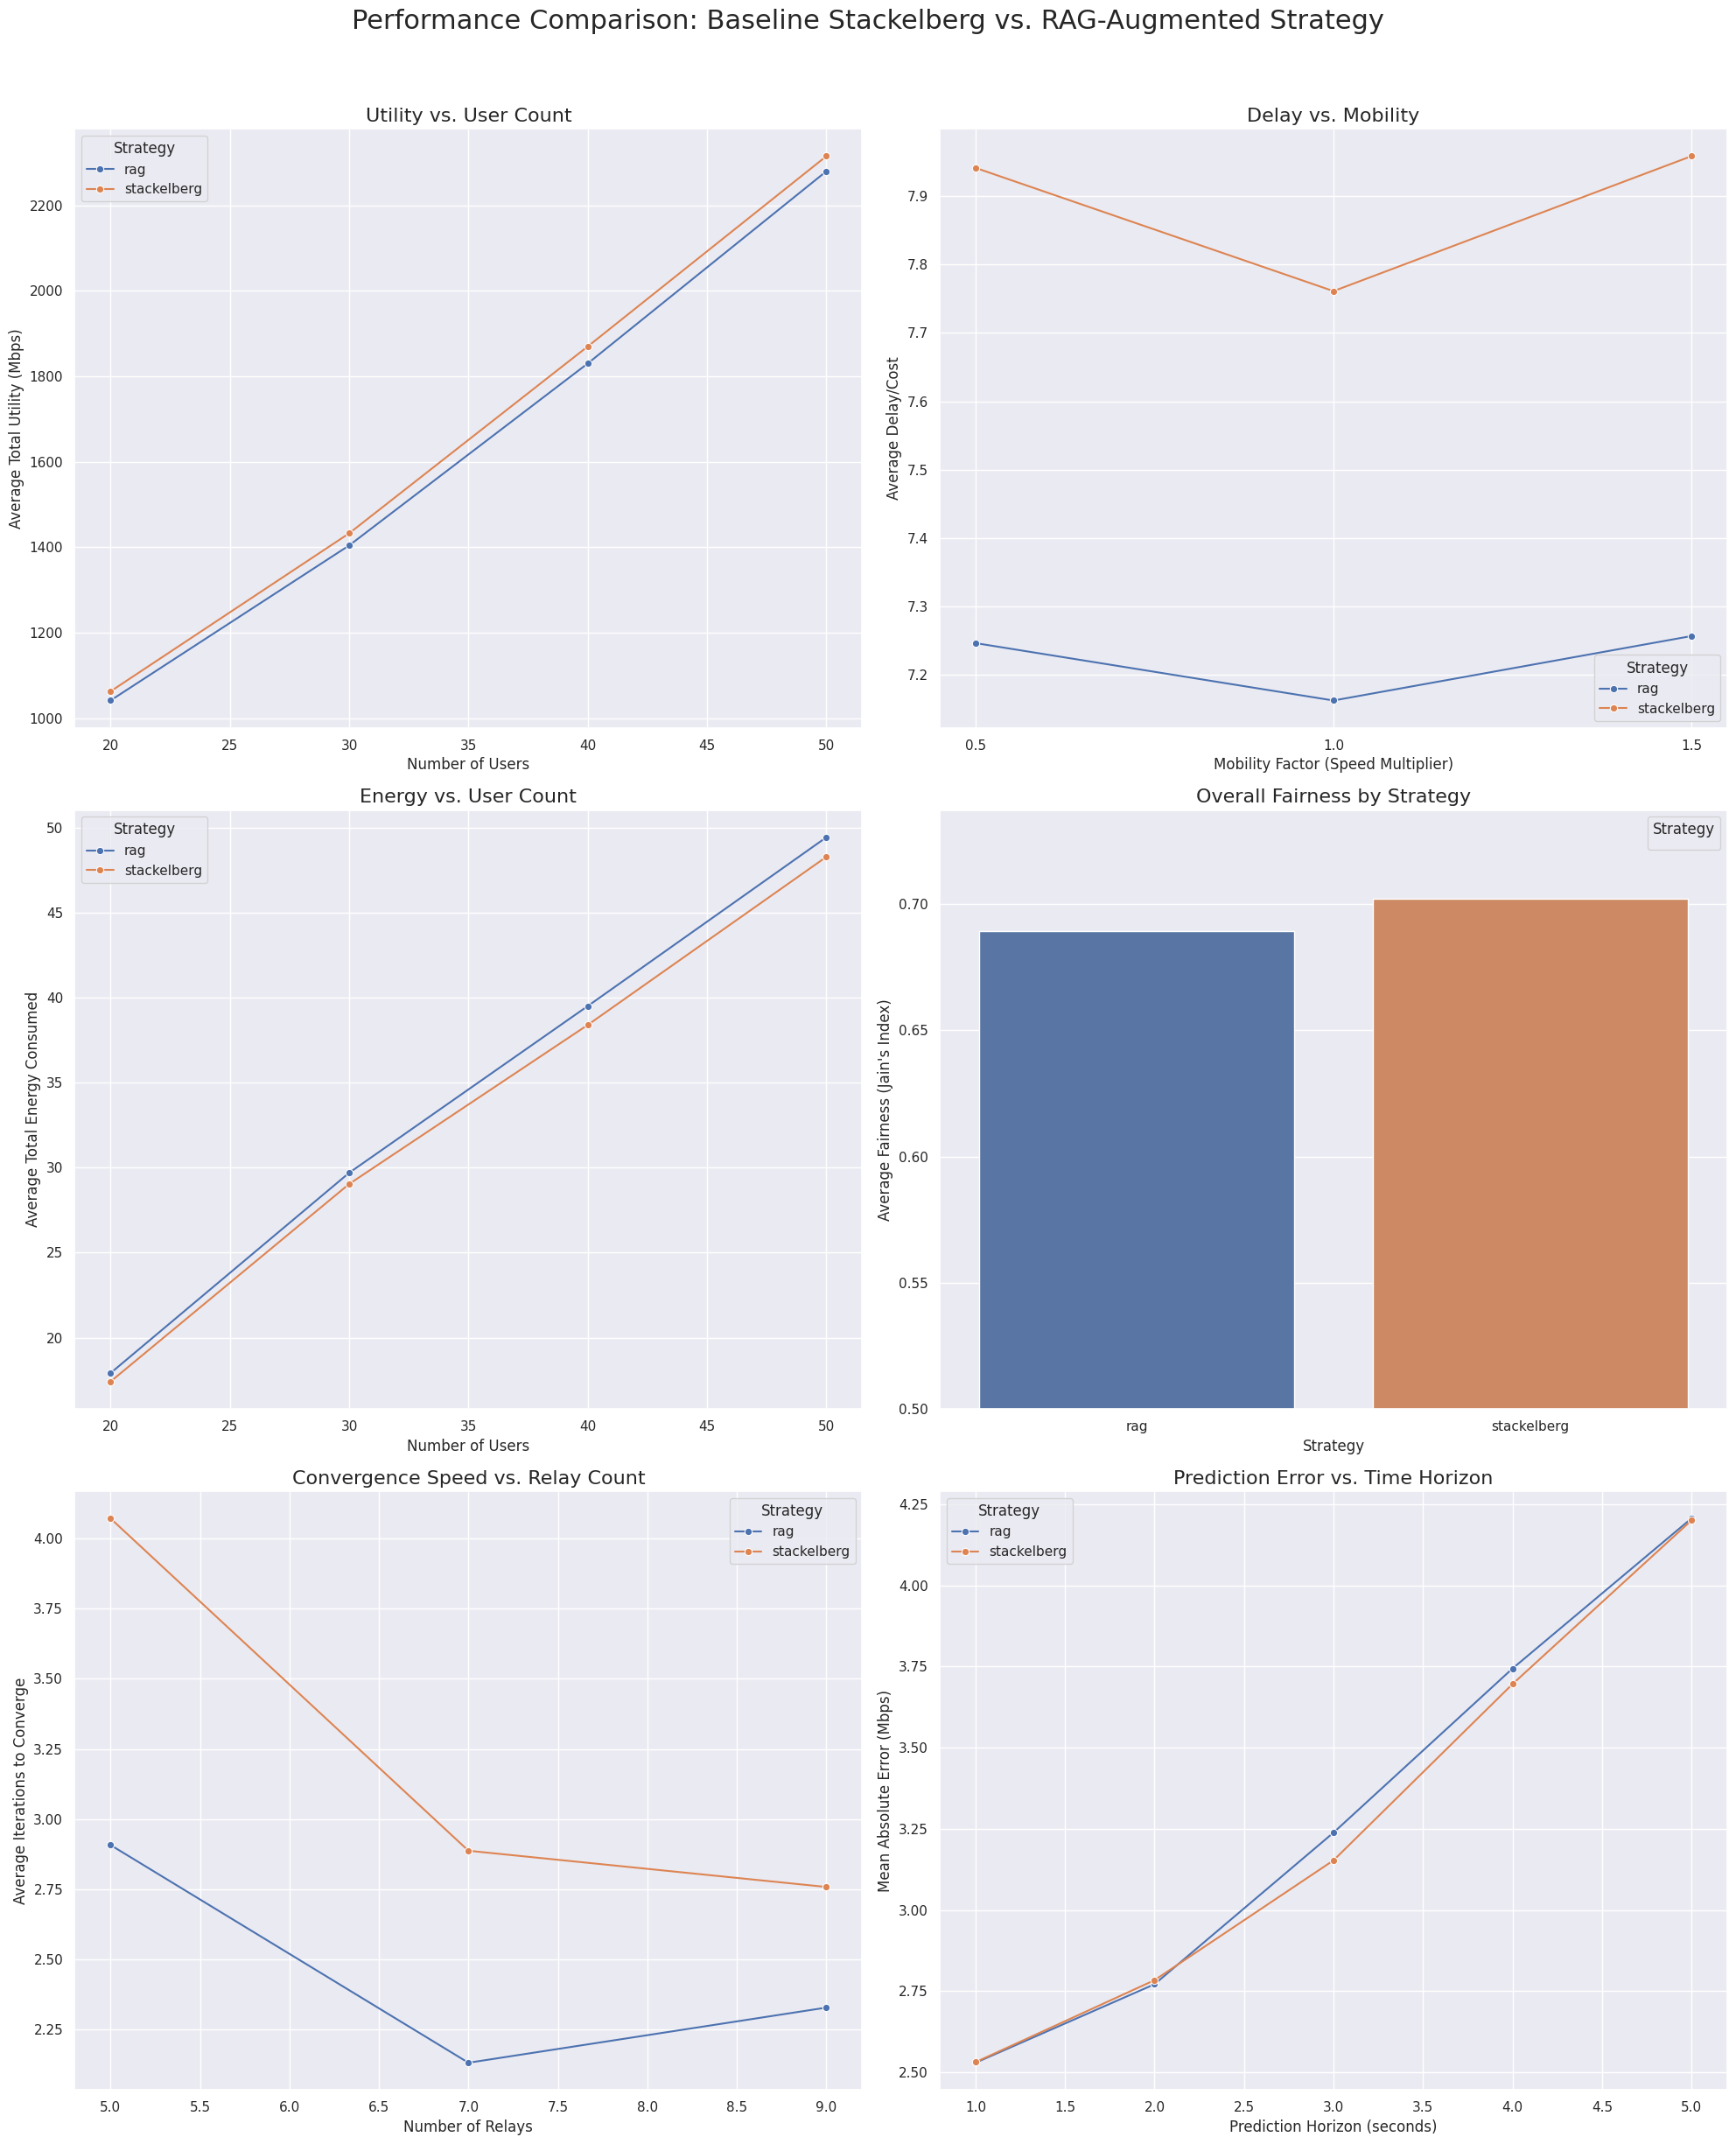


✅ All graphs generated and saved.


In [ ]:
# Block 4: Final Graph Generation

print("\n📊 Generating final comparison graphs...")
fig, axes = plt.subplots(3, 2, figsize=(20, 24))
fig.suptitle('Performance Comparison: Baseline Stackelberg vs. RAG-Augmented Strategy', fontsize=22, y=1.02)

# --- Aggregate data for plotting ---
# Group by the varying parameter and strategy, then calculate the mean of the metric
user_agg = results_df.groupby(['num_users', 'strategy']).mean().reset_index()
mobility_agg = results_df.groupby(['mobility', 'strategy']).mean().reset_index()
relay_agg = results_df.groupby(['num_relays', 'strategy']).mean().reset_index()
horizon_agg = results_df.groupby(['time_horizon', 'strategy']).mean().reset_index()
strategy_agg = results_df.groupby(['strategy']).mean().reset_index()

# Graph 1: Total system utility vs. number of users
sns.lineplot(data=user_agg, x='num_users', y='total_utility', hue='strategy', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Utility vs. User Count', fontsize=16)
axes[0, 0].set_xlabel('Number of Users')
axes[0, 0].set_ylabel('Average Total Utility (Mbps)')

# Graph 2: Delay vs Mobility
sns.lineplot(data=mobility_agg, x='mobility', y='avg_delay', hue='strategy', marker='o', ax=axes[0, 1])
axes[0, 1].set_title('Delay vs. Mobility', fontsize=16)
axes[0, 1].set_xlabel('Mobility Factor (Speed Multiplier)')
axes[0, 1].set_ylabel('Average Delay/Cost')
axes[0, 1].set_xticks(mobility_factors)

# Graph 3: Energy vs Users
sns.lineplot(data=user_agg, x='num_users', y='total_energy', hue='strategy', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Energy vs. User Count', fontsize=16)
axes[1, 0].set_xlabel('Number of Users')
axes[1, 0].set_ylabel('Average Total Energy Consumed')

# Graph 4: Fairness vs Strategy
sns.barplot(data=strategy_agg, x='strategy', y='fairness', hue='strategy', ax=axes[1, 1])
axes[1, 1].set_title('Overall Fairness by Strategy', fontsize=16)
axes[1, 1].set_xlabel('Strategy')
axes[1, 1].set_ylabel('Average Fairness (Jain\'s Index)')
axes[1, 1].set_ylim(bottom=0.5) # Fairness is usually high, zoom in

# Graph 5: Convergence vs Relays
sns.lineplot(data=relay_agg, x='num_relays', y='iterations', hue='strategy', marker='o', ax=axes[2, 0])
axes[2, 0].set_title('Convergence Speed vs. Relay Count', fontsize=16)
axes[2, 0].set_xlabel('Number of Relays')
axes[2, 0].set_ylabel('Average Iterations to Converge')

# Graph 6: Prediction Error vs Time Horizon
sns.lineplot(data=horizon_agg, x='time_horizon', y='prediction_error', hue='strategy', marker='o', ax=axes[2, 1])
axes[2, 1].set_title('Prediction Error vs. Time Horizon', fontsize=16)
axes[2, 1].set_xlabel('Prediction Horizon (seconds)')
axes[2, 1].set_ylabel('Mean Absolute Error (Mbps)')

# --- Final Touches ---
for ax in axes.flat:
    ax.legend(title='Strategy')
plt.tight_layout()
plt.show()

print("\n✅ All graphs generated.")